<a href="https://colab.research.google.com/github/danebencedavid/NLP-A-Agent/blob/master/npl_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦠 COVID-19 Research Agent
A QA Agent answering COVID-19, smoking, and diabetes related questions using graph-powered semantic search.



## **Imports and Downloading metadata of CORD19**

In [60]:
import kagglehub
import os
import pandas as pd
from nltk.corpus import wordnet
from tqdm import tqdm
import re
from nltk.stem import WordNetLemmatizer
import nltk
import requests
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import torch
from google.colab import drive
import shutil
import io
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/metadata.csv",low_memory=False)

In [ ]:
df.to_pickle('/content/drive/MyDrive/df.pkl')

In [2]:
df_meta_cord19 = pd.read_pickle('/content/drive/MyDrive/df.pkl')

In [3]:
print(f"Initial dataframe shape: {df_meta_cord19.shape}")

Initial dataframe shape: (1056660, 19)


In [4]:
df_meta_cord19 = df_meta_cord19[df_meta_cord19['abstract'].notnull()].copy()

In [5]:
print(f"Shape: {df_meta_cord19.shape}")

Shape: (821116, 19)


## **Defining core terms for COVID-19, smoking and diabetes**
Terms were gathered from [MeSH](https://www.ncbi.nlm.nih.gov/mesh/2052179/)

In [6]:
covid_terms = {
    "COVID-19", "SARS-CoV-2 infection", "coronavirus disease 2019",
    "2019-nCoV infection", "SARS-CoV-2 pathogenesis", "COVID-19 comorbidity",
    "coronavirus respiratory infection", "pandemic coronavirus",
    "post-COVID syndrome", "long COVID", "spike protein binding",
    "severe acute respiratory syndrome coronavirus 2", "COVID-19 pandemic",
    "ACE2 receptor binding", "viral respiratory infection"
}

smoking_terms = {
    "smoking", "tobacco use", "cigarette smoking", "nicotine",
    "tobacco smoke", "secondhand smoke", "vaping", "e-cigarette",
    "tobacco dependence", "smoking cessation", "COPD",
    "chronic obstructive pulmonary disease", "lung inflammation",
    "tobacco-induced inflammation", "smoking-related ACE2 expression",
    "cigarette smoke exposure", "pulmonary fibrosis",
    "respiratory epithelial damage", "nicotine addiction"
}

diabetes_terms = {
    "diabetes",
    "diabetic",
    "hyperglycemia",
    "blood sugar",
    "insulin resistance",
    "t2dm",
    "type 2 diabetes mellitus",
    "non-insulin-dependent diabetes mellitus",
    "niddm",
    "t1dm",
    "type 1 diabetes mellitus",
    "insulin-dependent diabetes mellitus",
    "iddm",
    "diabetes mellitus",
    "glucose metabolism disorders",
    "blood glucose",
    "insulin deficiency",
    "diabetic complications",
    "diabetic retinopathy",
    "diabetic neuropathy",
    "diabetic nephropathy",
    "cardiovascular disease and diabetes",
    "prediabetes",
    "gestational diabetes"
}




## **Semantic filtering based on Descriptions (abstracts)**

In [7]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
drive.mount('/content/drive')

NameError: name 'drive' is not defined

In [12]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")

def get_embeddings(texts, batch_size=128):
    return model.encode(texts, batch_size=batch_size, show_progress_bar=True)

def get_embeddings_incremental_save(texts, output_dir="abstract_embeddings", batch_size=128, start_index=0):
    os.makedirs(output_dir, exist_ok=True)

    for i in tqdm(range(start_index, len(texts), batch_size), desc="Encoding"):
        batch_texts = texts[i:i + batch_size]
        embeddings_batch = model.encode(batch_texts)

        # Save batch
        output_path = os.path.join(output_dir, f"embeddings_batch_{i//batch_size}.npy")
        np.save(output_path, embeddings_batch)

    # Load all saved embeddings (same as before)
    all_files = sorted([f for f in os.listdir(output_dir) if f.endswith(".npy")],
                      key=lambda x: int(x.split('_')[-1].split('.')[0]))
    return np.concatenate([np.load(os.path.join(output_dir, f)) for f in all_files], axis=0)

smoking_embeddings = model.encode(list(smoking_terms))
covid_embeddings = model.encode(list(covid_terms))
diabetes_embeddings = model.encode(list(diabetes_terms))

abstracts = df_meta_cord19['abstract'].tolist()
abstract_embeddings = get_embeddings_incremental_save(abstracts, output_dir="/content/drive/MyDrive/abs_embeddings")

Encoding: 100%|██████████| 6415/6415 [1:05:18<00:00,  1.64it/s]


In [13]:
output_drive_dir = "/content/drive/MyDrive/abs_embeddings"
all_loaded = []
for f in sorted([f for f in os.listdir(output_drive_dir) if f.endswith(".npy")],
                key=lambda x: int(x.split('_')[-1].split('.')[0])):
    all_loaded.append(np.load(os.path.join(output_drive_dir, f)))
abstract_embeddings = np.concatenate(all_loaded, axis=0) if all_loaded else np.array([])

In [14]:
def batch_cosine_similarity(query_embeddings, target_embeddings, batch_size=1000):
    similarities = []
    for i in range(0, len(target_embeddings), batch_size):
        batch = target_embeddings[i:i+batch_size]
        sim_batch = cosine_similarity(batch, query_embeddings)
        similarities.append(sim_batch)
    return np.concatenate(similarities, axis=0)

In [15]:
print("Calculating smoking relevance...")
smoking_similarities = batch_cosine_similarity(smoking_embeddings, abstract_embeddings)
max_smoking_sim = np.max(smoking_similarities, axis=1)

print("Calculating COVID relevance...")
covid_similarities = batch_cosine_similarity(covid_embeddings, abstract_embeddings)
max_covid_sim = np.max(covid_similarities, axis=1)

print("Calculating diabetes relevance...")
diabetes_similarities = batch_cosine_similarity(diabetes_embeddings, abstract_embeddings)
max_diabetes_sim = np.max(diabetes_similarities, axis=1)


Calculating smoking relevance...
Calculating COVID relevance...
Calculating diabetes relevance...


In [16]:
print("Shape of max_smoking_sim:", max_smoking_sim.shape)
print("Shape of max_covid_sim:", max_covid_sim.shape)
print("Shape of max_diabetes_sim:", max_diabetes_sim.shape)


Shape of max_smoking_sim: (821116,)
Shape of max_covid_sim: (821116,)
Shape of max_diabetes_sim: (821116,)


In [86]:
weight_smoking = 0.65
weight_covid = 0.35
#weight_diabetes = 0.3
combined_scores = (weight_smoking * max_smoking_sim +
                   weight_covid * max_covid_sim) #+
                   #weight_diabetes * max_diabetes_sim)
threshold = np.percentile(combined_scores, 99.99)

In [99]:
mean_score = np.mean(combined_scores)
std_score = np.std(combined_scores)
threshold = 1.41*(mean_score + 2 * std_score)

In [100]:
relevant_mask = combined_scores >= threshold
relevant_papers = df_meta_cord19.iloc[relevant_mask].copy()
relevant_papers['smoking_score'] = max_smoking_sim[relevant_mask]
relevant_papers['covid_score'] = max_covid_sim[relevant_mask]
#relevant_papers['diabetes_score'] = max_diabetes_sim[relevant_mask]
relevant_papers['combined_score'] = combined_scores[relevant_mask]


In [101]:
print(f"Found {len(relevant_papers)} relevant papers (threshold: {threshold:.3f})")

Found 44 relevant papers (threshold: 0.658)


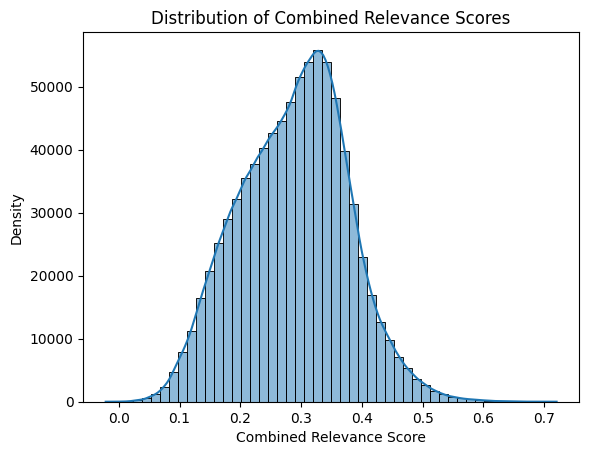

In [102]:
sns.histplot(combined_scores, kde=True, bins=50)
plt.xlabel("Combined Relevance Score")
plt.ylabel("Density")
plt.title("Distribution of Combined Relevance Scores")
plt.show()

In [103]:
relevant_papers.to_csv("/content/drive/MyDrive/relevant_papers_4.csv", index=False)

In [ ]:
relevant_papers